# Manifold Learning

## Intro

A **manifold** is a topological space that locally resembles Euclidean space near each point. More formally, each point of an n-dimensional manifold has a neighbourhood that is homeomorphic to Euclidean space of dimension n. <br>
<br>
Manifold learning is a class of methods for non-linear dimensionality reduction. Many high dimensional datasets can be represented as lower dimensional manifolds that are embedded in this high dimensional space. We seek to learn this lower dimensional representation, sometimes referred to as the intrinsic dimensionality, of the data. <br>
<br>
In this notebook, I go over some of the methods of non-linear dimensionality reduction and manifold learning in more detail. <br>

![title](manifold5-1.png)

In [4]:
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import seaborn as sns

from IPython.display import Image

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

import warnings
warnings.filterwarnings('ignore');

## Locally Linear Embedding

- **Local Linear Embedding (LLE)** Local linear Embedding seeks a mapping of the data to a lower dimension which preserves local linear relationships within neighborhoods.

We show a few examples first before going through implementation and algorithm details

### 3D examples

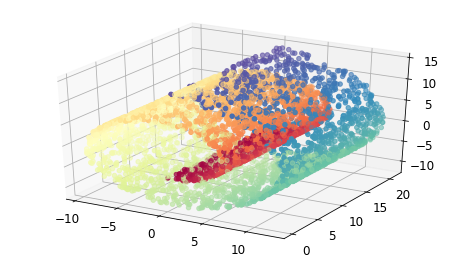

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

# swiss roll dataset
from sklearn.datasets.samples_generator import make_swiss_roll
X, color = make_swiss_roll(n_samples = 5000)
%matplotlib inline
fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral);

This toy dataset shows nonlinear relationships in 3D. A reasonable approximation for this data is a 2D manifold embedded in a higher dimension, as you can see the locally approximate linear relationships of the data.

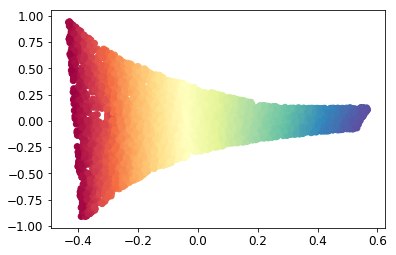

In [30]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)
X_reduced = X_reduced*20
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, cmap=plt.cm.Spectral);

Using scikit-learn's LLE implementation, we can preserve the intrinsic structure of the dataset with this mapping to 2 dimensions. The points within each of the local neighbourhoods in 3 dimensions are also close to the same neighboring points in 2 dimensions.

A few more examples:

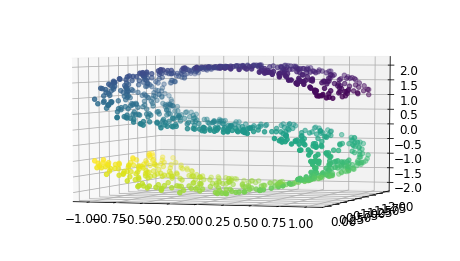

In [64]:
from sklearn.datasets.samples_generator import make_s_curve
X, color = make_s_curve(1000, random_state=0)
fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color)
ax.view_init(4, -72);

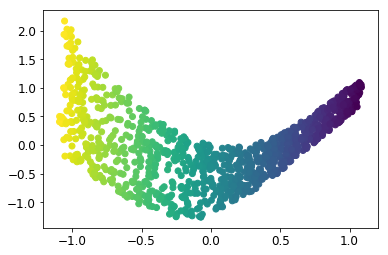

In [65]:
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)
X_reduced = X_reduced*20
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color);

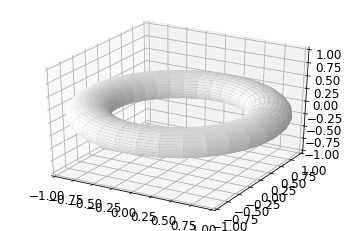

In [77]:
# Generate torus mesh
angle = np.linspace(0, 2 * np.pi, 32)
theta, phi = np.meshgrid(angle, angle)
r, R = .25, 1.
X = (R + r * np.cos(phi)) * np.cos(theta)
Y = (R + r * np.cos(phi)) * np.sin(theta)
Z = r * np.sin(phi)

# Display the mesh
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
ax.plot_surface(X, Y, Z, color = 'w', rstride = 1, cstride = 1)
plt.show();

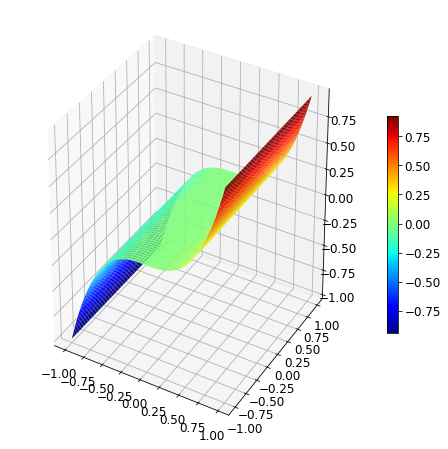

In [75]:
f = plt.figure(figsize=(8,8))
a = f.gca(projection='3d')
x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
X, Y = np.meshgrid(x,y)
Z = X**3
s = a.plot_surface(X,Y,Z,cmap=plt.cm.jet)
f.colorbar(s,shrink=0.5)
plt.show();

In [143]:
ipv.pylab.clear()
x_saddle = np.arange(-5, 5)
y_saddle = np.arange(-5, 5)
x_saddle, y_saddle = np.meshgrid(x_saddle, y_saddle)
z_saddle = x_saddle**2/10. - y_saddle**2/10

ipv.plot_surface(x_saddle, z_saddle, y_saddle, color="blue")
ipv.plot_wireframe(x_saddle, z_saddle, y_saddle, color="red")
ipv.show()

Mesh(color=array('blue', dtype='<U4'), line_material=ShaderMaterial(), material=ShaderMaterial(side='DoubleSid…

Mesh(line_material=ShaderMaterial(), lines=array([[ 0, 10],
       [ 0,  1],
       [ 1, 11],
       [10, 11],…

In [144]:
# f(u, v) -> (u, v, u*v**2)
import ipyvolume as ipv
ipv.pylab.clear()
a = np.arange(-4, 4)
U, V = np.meshgrid(a, a)
X = U
Y = V
Z = X*Y**2

ipv.plot_surface(X, Z, Y, color="blue")
ipv.plot_wireframe(X, Z, Y, color="red")
ipv.show()

Mesh(color=array('blue', dtype='<U4'), line_material=ShaderMaterial(), material=ShaderMaterial(side='DoubleSid…

Mesh(line_material=ShaderMaterial(), lines=array([[ 0,  8],
       [ 0,  1],
       [ 1,  9],
       [ 8,  9],…

### Algorithm

**Step 1**: Define each data point $X_i$ in terms of its local linear relationships. <br>  
We have to define a parameter k to specify the number of nearest neighbors we consider. Then, for each $X_i$ in dimension D, we reconstruct $X_i$ using a linear combination of its k nearest neighbors. Note: this linear combination reconstruction is also in dimension D.  

For each point $X_i$ we define a linear combination with the weight matrix $W$ and its nearest neighbors $X_j$ and we have the reconstruction error defined by cost function: <br>
$$\mathcal{E}(W) = \sum_{i} |X_i - \sum_{j} W_{ij} X_j|^2$$
This has a residual sum of squares form where we have the error as the Euclidean distance between the original $X_i$ and our nearest neighbors construction

For our weight matrix W, we have

$$\mathbf{W} = \begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n} \\
w_{21} & w_{22} & \cdots & w_{2n} \\
\vdots & \vdots & \vdots & \vdots \\
w_{n1} & w_{n2} & \cdots & w_{nn}
\end{bmatrix}$$ <br>
where $\sum_{j} W_{ij} X_j = W_{i1} X_{1} + \cdots + W_{in} X_{n}$ gives the linear combination for $X_i$ 

We have two constraints on $W$: <br>
- $W_{ij} = 0$ if $X_{j}$ not one of the nearest neighbors for a given $X_i$ (we only consider the local neighborhood) <br>
- The rows of the weight matrix sum to one: $\sum_{j} W_{ij} = 1$

Now we show an example illustrating this step.

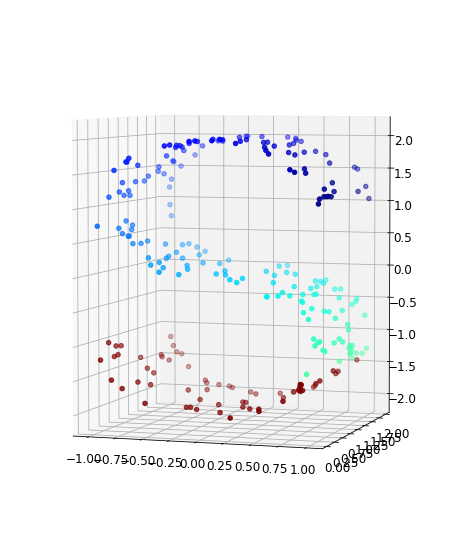

In [217]:
from sklearn.datasets.samples_generator import make_s_curve
X, color = make_s_curve(250, random_state=0)
color[color > 2] = 10
fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.jet)
ax.view_init(4, -72);

From the example above, we have a dataset that we take to be an embedded 2D manifold (locally resembles flat Euclidean space) in this higher dimensional 3D space. We consider a local neighborhood and visualize how we can use linear combinations to represent the intrinsic geometry.

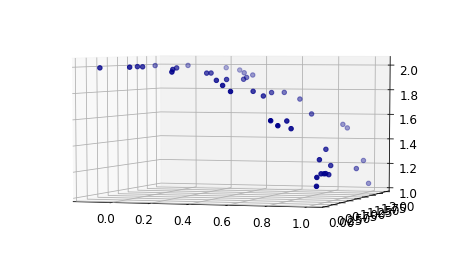

In [246]:
fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(211, projection='3d')
neighborhood = X[color < -3]
ax.scatter(neighborhood[:, 0], neighborhood[:, 1], neighborhood[:, 2], c='darkblue')
#ax.plot(neighborhood[:, 0], neighborhood[:, 1], neighborhood[:, 2], c='black')
ax.view_init(4, -72);

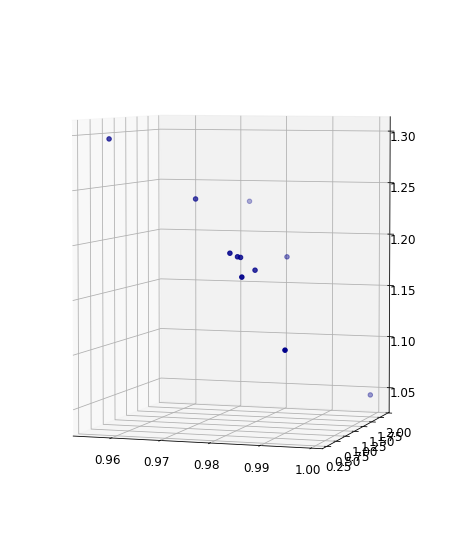

In [247]:
fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(111, projection='3d')
neighborhood = X[color < -3]
neighborhood = neighborhood[neighborhood[:, 2] < 1.5]
neighborhood = neighborhood[neighborhood[:, 0] > 0.94]
ax.scatter(neighborhood[:, 0], neighborhood[:, 1], neighborhood[:, 2], c='darkblue')
ax.view_init(4, -72);

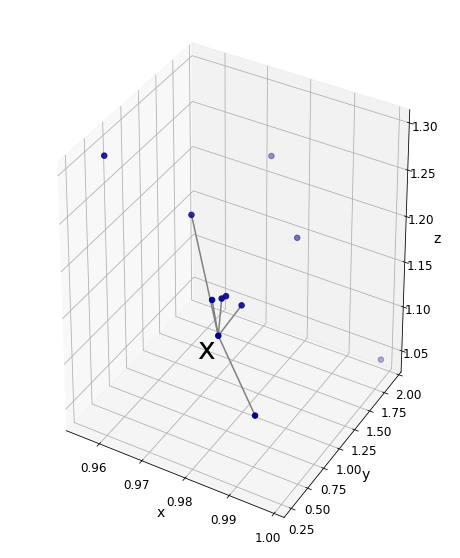

In [279]:
fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(111, projection='3d')
neighborhood = X[color < -3]
neighborhood = neighborhood[neighborhood[:, 2] < 1.5]
neighborhood = neighborhood[neighborhood[:, 0] > 0.94]
ax.scatter(neighborhood[:, 0], neighborhood[:, 1], neighborhood[:, 2], c='darkblue', s=30)
ax.plot(neighborhood[5:7, 0], neighborhood[5:7, 1], neighborhood[5:7, 2], c='gray')
ax.plot(neighborhood[[6,10], 0], neighborhood[[6,10], 1], neighborhood[[6,10], 2], c='gray')
ax.plot(neighborhood[[6,9], 0], neighborhood[[6,9], 1], neighborhood[[6,9], 2], c='gray')
ax.plot(neighborhood[[6,1], 0], neighborhood[[6,1], 1], neighborhood[[6,1], 2], c='gray')
ax.plot(neighborhood[[6,0], 0], neighborhood[[6,0], 1], neighborhood[[6,0], 2], c='gray')
ax.text(neighborhood[6, 0], neighborhood[6, 1] - 0.3, neighborhood[6, 2], s='x', size=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
#ax.view_init(5, 2);

By the way we defined the cost function, the optimal weights are invariant to rotation, scaling, and translation, so they reflect intrinsic geometric properties of the original data space. There exists an approximately linear mapping (translation, rotation, and rescaling) that maps $X_i$ to the lower dimensional manifold. Therefore, since the weights are invariant, these same optimal weights that reconstruct $X_i$ in D dimensions (as described above), also reconstruct the embedded manifold coordinates of $X_i$ in d dimensions.

**Step 2**: Construct the mapping from each $X_i$ in D to its lower dimensional manifold representation $Y_i$ in d. <br>  
Since the optimal weights we found have certain invariant properties, we use these weights in this mapping. We define a new cost function with a similar form to the previous one, where we want to minimize reconstruction error

$$\phi(Y) = \sum_{i} |Y_i - \sum_{j} (W_{ij} Y_j)|^2$$

This time, we fix the weights and optimize the coordinates $Y_i$ <br>
<br>
The Locally Linear Embedding algorithm has only one parameter k = number of nearest neighbors to consider, and then requires solving both optimization problems: <br>
1. Compute the optimal weights of the nearest neighbors linear reconstruction <br>
2. Compute the optimal lower dimensional coordinates that preserve local geometric structure

### Optimization problems

**A. Optimal weights: Constrined Least Squares Problem**: To find the weights that minimize $$\mathcal{E}(W) = \sum_{i} |X_i - \sum_{j} W_{ij} X_j|^2$$
subject to the constraints, consider a particular $X_i$:  $$\mathcal{E} = |X_i - \sum_{j} W_{ij} \eta_j|^2$$
and since sum of weights = 1, we have $$\mathcal{E} = |\sum_{j} W_{ij}X_i - \sum_{j} W_{ij} \eta_j|^2$$
which gives: $$\mathcal{E} = |\sum_{j} W_{ij} (X_i - \eta_j)|^2$$
and $$\mathcal{E} = \sum_{jk} w_j w_k C_{jk}$$

Here C is the local covariance matrix where $$C_{jk} = (X_i - \eta_j) * (X_i - \eta_k)$$

We can solve the system of linear equations $$\sum_{j} C_{jk} w_k = 1$$
and finally rescale weights to sum to 1, finally yielding: 
$$w_j = \frac{\sum_k C_{jk}^{-1}}{\sum_{lm} C_{lm}^{-1}}$$
which gives the optimal weights that minimize our optimization problem

**B. Optimal embedding coordinates**:

### Python Implementation

## LLE on real datasets